# SEE - Data science Challenge

## INIT
Initialize the librraries used for the project.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm


import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Disable warnings from tensorflow. Nobody reads them anyways ;)

## FLAGS
Light Configurations to the script can be made here.

In [61]:


#FLAGS
NUM_CLASSES = 3 #Number of classes to predict
VALIDATION_SPLIT = 0.2 #Percentage split of TRAIN & VAL
IMAGE_SIZE = (332, 332) #Size of images fed to the network 
BATCH_SIZE = 128
DATA_NAME = "SEE" #Folder to store data in case of multiple projects
EPOCHS = 20 #Number of epochs to train the model
STORAGE_PREFIX = "/content/" #Udes in google colab. Can be set to "" when developing locally
BIT_MODEL_URL = "https://tfhub.dev/google/bit/m-r50x1/1" #BiT model to use. Models can be found at https://tfhub.dev/

In [49]:
# Create folder to store data
try:
  os.mkdir(f"data") 
  os.mkdir(f"data/{DATA_NAME}")
except:
  pass


## DATA

## Data ETL

In [50]:
# Extract images from website
import requests, zipfile, io
r = requests.get("https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train_test_data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(STORAGE_PREFIX+"data")

In [51]:
# Load Excel Files from website
df_train = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/train.csv')
df_test = pd.read_csv('https://challenges-asset-files.s3.us-east-2.amazonaws.com/data_sets/Data-Science/4+-+events/SchneiderElectricEuropeanHackathon22/test.csv')

In [ ]:
#Data Analysis
def get_count(x=df_train['label']):
  import seaborn as sns
  sns.countplot(x=x)
  plt.savefig("foo.png")

In [62]:
# Load data into new folder structure compatible with keras preprocessing
for i,row in tqdm(df_train.iterrows()):
    path = f"data/{DATA_NAME}/{row.label}/"
    try: 
        os.mkdir(path) 
    except: 
        pass
    shutil.copyfile(f"data/{row.example_path}", path+row.example_path.split('/')[-1])

1714it [00:00, 1840.43it/s]


## Data Pre-Processing

In [63]:
# Load and split data into test and train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"data/{DATA_NAME}",
    validation_split=VALIDATION_SPLIT,
    seed=SEEDS,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset = "training"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f"data/{DATA_NAME}",
    validation_split=VALIDATION_SPLIT,
    seed=SEEDS,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset = "validation"
)



Found 1714 files belonging to 3 classes.
Using 1372 files for training.
Found 1714 files belonging to 3 classes.
Using 342 files for validation.


In [64]:
# Define how to augment the data
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.Rescaling(1./255), # Normalize values
    ]
)

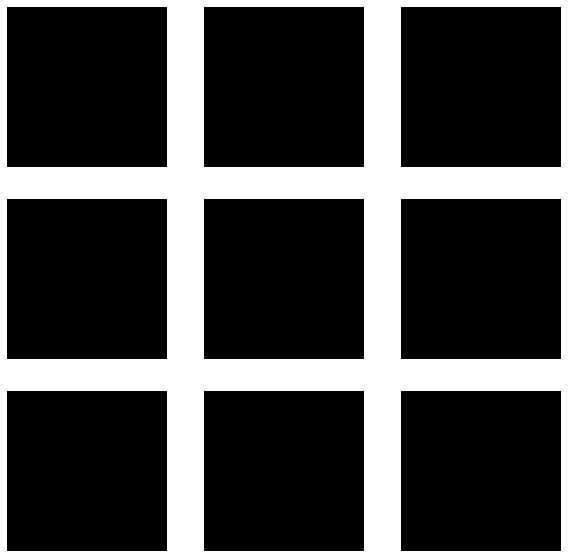

In [55]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
# Since all images have been normalized with pixel values between 0 and 1, its hard to distigusih the images with the human eye. The ML model however finds it easy*.

In [65]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE,
) # Apply the augmentation to the train data

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [10]:
# Get BiT model from the hub
bit_module = hub.KerasLayer(BIT_MODEL_URL,trainable=False)

In [66]:
# Define a model with a new head and the BiT module
class BiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = BiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [70]:
# Define the optimizer and loss function of the model
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [68]:
# Define callbacks for model if you with to do so. I have choosen to disable the callbacks.
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True,
    ),
    keras.callbacks.ModelCheckpoint("models/save_at_{epoch}.keras")
]

In [71]:
#Fit the model on the training data
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    #callbacks=train_callbacks,
    validation_data=val_ds,
)

Epoch 1/20
6/6 [==============================] - 50s 7s/step - loss: 1.1054 - accuracy: 0.5598 - val_loss: 0.8626 - val_accuracy: 0.6287
Epoch 2/20
6/6 [==============================] - 48s 7s/step - loss: 0.7297 - accuracy: 0.7070 - val_loss: 0.9322 - val_accuracy: 0.6316
Epoch 3/20
6/6 [==============================] - 45s 6s/step - loss: 0.7199 - accuracy: 0.7092 - val_loss: 0.6406 - val_accuracy: 0.7310
Epoch 4/20
6/6 [==============================] - 44s 6s/step - loss: 0.6239 - accuracy: 0.7515 - val_loss: 0.6858 - val_accuracy: 0.7193
Epoch 5/20
6/6 [==============================] - 45s 6s/step - loss: 0.5923 - accuracy: 0.7762 - val_loss: 0.6695 - val_accuracy: 0.7251
Epoch 6/20
6/6 [==============================] - 49s 6s/step - loss: 0.5751 - accuracy: 0.7682 - val_loss: 0.6948 - val_accuracy: 0.6871
Epoch 7/20
6/6 [==============================] - 47s 6s/step - loss: 0.5774 - accuracy: 0.7711 - val_loss: 0.6553 - val_accuracy: 0.7427
Epoch 8/20
6/6 [==================

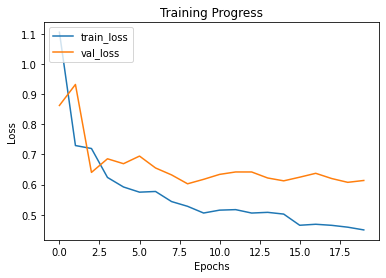

In [76]:
# Plot the training progress using either loss or accuracy
def plot_hist(hist,loss=True):
  if loss:
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.ylabel("Loss")
    plt.legend(["train_loss", "val_loss"], loc="upper left")
  else:
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.ylabel("Accuracy")
    plt.legend(["train_acc", "val_acc"], loc="upper left")

  plt.title("Training Progress")
  plt.xlabel("Epochs")
  plt.savefig("foo2.png")
  plt.show()


plot_hist(history,True)

In [73]:
# Print final validation accuracy
accuracy = model.evaluate(val_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

2/2 [==============================] - 7s 1s/step - loss: 0.6139 - accuracy: 0.7485
Accuracy: 74.85%


In [74]:
directory = "data/train_test_data/test"
 
# iterate over files in
# that directory

final_dict = {"target":{}}
for filename in tqdm(os.listdir(directory)):
    f = os.path.join(directory, filename)
    img = keras.preprocessing.image.load_img(
    f, target_size=IMAGE_SIZE
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = list(model.predict(img_array,verbose=0)[0])
    final_dict['target'][filename.split('.')[0]] = predictions.index(max(predictions))




100%|██████████| 635/635 [01:02<00:00, 10.24it/s]


In [46]:
import json

with open('predictions.json', 'w') as fp:
    json.dump(final_dict, fp)